# Install


In [46]:
!pip install levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.0/174.0 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.0 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Config

In [152]:
SUBMISSIONS = ["blosum","ddg","demask","plddt","plddtdiff","rmsd","rosetta","sasa","thermonet","0338_ros_r1","0472_roset","0482_p3","0488_term","0499_roset_v2","0603_del_spec","0608","0613","0614","0615","0615_new"]
VALIDATORS = ["submission_v2.csv","submission_v3.csv","submission_v4.csv"]
TEST_CSV = '/content/drive/MyDrive/work/projects/Novozymes/data/test.csv'


# Lib

In [186]:
from matplotlib import pyplot
from scipy.stats import pearsonr, spearmanr
from scipy.stats.stats import rankdata
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import metrics
from tqdm import tqdm
import os
import Levenshtein

def gen_mutations(name, df,
                  wild="VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQ""RVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGT""NAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKAL""GSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK"):
    result = []
    for _, r in df.iterrows():
        ops = Levenshtein.editops(wild, r.protein_sequence)
        assert len(ops) <= 1
        if len(ops) > 0 and ops[0][0] == 'replace':
            idx = ops[0][1]
            result.append([ops[0][0], idx + 1, wild[idx], r.protein_sequence[idx]])
        elif len(ops) == 0:
            result.append(['same', 0, '', ''])
        elif ops[0][0] == 'insert':
            assert False, "Ups"
        elif ops[0][0] == 'delete':
            idx = ops[0][1]
            result.append(['delete', idx + 1, wild[idx], '-'])
        else:
            assert False, "Ups"

    df = pd.concat([df, pd.DataFrame(data=result, columns=['op', 'idx', 'wild', 'mutant'])], axis=1)
    df['mut'] = df[['wild', 'idx', 'mutant']].astype(str).apply(lambda v: ''.join(v), axis=1)
    df['name'] = name
    return df

def norm_rank_df(df):
  df.tm = rankdata(df.tm)
  df.tm = df.tm / df.tm.max()
  return df

def norm_min_max_df(df):
  df.tm = (df.tm - df.tm.min())/(df.tm.max() - df.tm.min())
  return df

def check(submission):
  check_csv(f'submission_{submission}.csv')

def check_csv(file_name):
  df = pd.read_csv(file_name) 

  val_ss = [pd.read_csv(val_file) for val_file in VALIDATORS ]
  val_ss_sp_arr = [spearmanr(norm_rank_df(dfs).tm, norm_rank_df(df).tm).correlation for dfs in val_ss]
  val_ss_sp = np.mean(val_ss_sp_arr)
  hist = plt.hist(df.tm)
  print(f'{file_name}: ')

  print(f'val_sp: {val_ss_sp:.4f}')
  print(f'\tcorrelation with: ')
  for score in SUBMISSIONS:
    df_other = pd.read_csv(f'submission_{score}.csv')
    print(f'\t sp: {spearmanr(norm_rank_df(df).tm, norm_rank_df(df_other).tm).correlation:.4f}, p: {pearsonr(norm_min_max_df(df).tm, norm_min_max_df(df_other).tm)[0]:.4f} -> {score}')
  
  print(hist)

def build_submit(replace_submit, delete_submit):
    df_test = gen_mutations('wildtypeA', pd.read_csv(TEST_CSV))
    replace_ids = df_test.loc[df_test.op == 'replace', 'seq_id']
    delete_ids  = df_test.loc[df_test.op == 'delete',  'seq_id']
    df_test = df_test.set_index('seq_id')
    replace_submit = replace_submit.set_index('seq_id')
    delete_submit = delete_submit.set_index('seq_id')

    # replacement mutations
    df_test.loc[replace_ids, 'ddg'] = replace_submit.loc[replace_ids,'tm']
    # deletion mutations
    df_test.loc[delete_ids, 'ddg'] = delete_submit.loc[delete_ids,'tm']
    # no mutations
    df_test.loc[df_test['op'] == "same", 'ddg'] = 0.  

    df_test = df_test.reset_index()

    df = df_test.rename(columns={'ddg': 'tm'})[['seq_id', 'tm']]
    return df

def ensamble_rank(subissions, weights):
  dfe   = pd.read_csv(f'submission_{subissions[0]}.csv')
  coeff = 1.0/len(subissions)   
  dfe.tm = 0.0*dfe.tm
  for i,subission in enumerate(subissions):
    if weights is not None:
      coeff = weights[i]
    #print(f'{coeff}x{subission}')
    dfs = pd.read_csv(f'submission_{subission}.csv')
    #dfs = norm_rank_df(dfs)
    dfe.tm += coeff*rankdata(dfs.tm)
  dfe.tm /= dfe.tm.max()
  return dfe
   
def ensamble(repl_submissions, repl_weights, del_submissions, del_weights, out_file_name):
  replace_submit = ensamble_rank(repl_submissions, repl_weights)
  if del_submissions is None:
    del_submissions = repl_submissions
    del_weights = repl_weights
  delate_submit  = ensamble_rank(del_submissions, del_weights)
  df = build_submit(replace_submit,delate_submit)
  df.tm = rankdata(df.tm)
  df.to_csv(out_file_name, index=False) 



# Ensemble

submission.csv: 
val_sp: 0.6145
	correlation with: 
	 sp: 0.3151, p: 0.3151 -> blosum
	 sp: 0.7088, p: 0.7088 -> ddg
	 sp: 0.6973, p: 0.6973 -> demask
	 sp: 0.5045, p: 0.5045 -> plddt
	 sp: 0.4808, p: 0.4808 -> plddtdiff
	 sp: 0.6639, p: 0.6639 -> rmsd
	 sp: 0.7688, p: 0.7688 -> rosetta
	 sp: 0.7365, p: 0.7365 -> sasa
	 sp: 0.8313, p: 0.8313 -> thermonet
	 sp: 0.4973, p: 0.4973 -> 0338_ros_r1
	 sp: 0.7634, p: 0.7634 -> 0472_roset
	 sp: 0.7524, p: 0.7524 -> 0482_p3
	 sp: 0.7866, p: 0.7866 -> 0488_term
	 sp: 0.7945, p: 0.7945 -> 0499_roset_v2
	 sp: 0.9819, p: 0.9819 -> 0603_del_spec
	 sp: 0.9902, p: 0.9902 -> 0608
	 sp: 0.9930, p: 0.9930 -> 0613
	 sp: 0.9958, p: 0.9958 -> 0614
	 sp: 0.9965, p: 0.9965 -> 0615
	 sp: 0.9975, p: 0.9975 -> 0615_new
(array([242., 241., 241., 241., 241., 242., 241., 241., 241., 242.]), array([4.14421881e-04, 1.00372980e-01, 2.00331538e-01, 3.00290095e-01,
       4.00248653e-01, 5.00207211e-01, 6.00165769e-01, 7.00124327e-01,
       8.00082884e-01, 9.00041442e-0

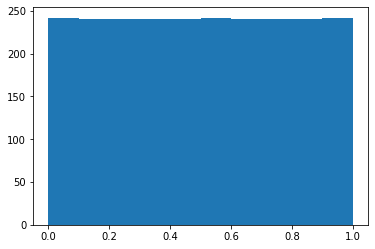

In [203]:
#test$tm<- (4*rosetta + 2*rmsd + 2*thermonet + 2*plddtdiff + sasa + plddt + demask + ddg + blosum) / 14
#test[idx,'tm'] <- (2*plddt[idx] + 2*plddtdiff[idx] + rmsd[idx] + sasa[idx]) / 6

# orig
#ensamble(['rosetta','rmsd','thermonet','plddtdiff','sasa','plddt','demask','ddg','blosum'], 
#         np.array([4,2,2,2,1,1,1,1,1])/14,
#         ['plddt','plddtdiff','rmsd','sasa'], 
#         np.array([2,2,1,1])/6,
#         'submission.csv')

# 6147
#ensamble(['rosetta', '0482_p3', '0338_ros_r1', 'rmsd','thermonet','plddtdiff','sasa','plddt','demask','ddg','blosum','rasp'], 
#         np.array([4,3.2,2,2,2,2,1,1,1,1,1,0.0])/14,
#         ['plddt','plddtdiff','rmsd','sasa'], 
#         np.array([2,2,1,1])/6,
#         'submission.csv')

#ensamble(['rosetta', '0499_roset_v2', '0482_p3', '0338_ros_r1','0347_ros_r2','rmsd','thermonet','plddtdiff','sasa','plddt','demask','ddg','blosum','rasp'], 
#         np.array([4,2,3.2,2,1,2,2,2,1,1,1,1,1,0.0])/14,
#         ['plddt','plddtdiff','rmsd','sasa'], 
#         np.array([2,2,1,1])/6,
#         'submission.csv')
# 608

#ensamble(['rosetta','0482_p3','0338_ros_r1','rmsd','thermonet','plddtdiff','sasa','plddt','demask','ddg','blosum'], 
#         np.array([4,2.5,2,2,2,2,1,1,1,1,1])/18.5,
#         ['plddt','plddtdiff','rmsd','sasa'], 
#         np.array([2,2,1,1])/6,
#         'submission.csv')

ensamble(['0499_roset_v2','0615_new'], 
         np.array([0.0, 1.0]),
         None, 
         None,
         'submission.csv')

check_csv('submission.csv')

!head submission.csv



In [58]:
df.head()

,seq_id,tm
0,31390,2364.75
1,31391,2334.75
2,31392,623.00
3,31393,1252.50
4,31394,839.50


In [79]:


df = pd.read_csv('submission_0590.csv')

build_csv(df, df, 'submission.csv')
!head 'submission.csv'


2335
seq_id,tm
31390,2364.75
31391,2334.75
31392,623.0
31393,1252.5
31394,839.5
31395,1369.0
31396,836.5
31397,1747.0
31398,2058.0


In [77]:
df_test = gen_mutations('wildtypeA', pd.read_csv(TEST_CSV))

df_test = df_test.set_index('seq_id')


df_test.loc[[31390]]


,protein_sequence,pH,data_source,op,idx,wild,mutant,mut,name
seq_id,,,,,,,,,
31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,17,L,E,L17E,wildtypeA


# Train weights

In [ ]:
from scipy.optimize import fmin

val_ss = [pd.read_csv(f'/content/drive/MyDrive/work/projects/g2net/datasets/validators/ss/validator_m77{i}.csv') for i in ['a','b','c','d','e'] ]

models = ["695_s", "720", "726", "750_5", "763_04", "740_27", "739_38", "745_44", "748_230", "748v_86", "748v_87", "744_207", "739_210", "740_81"]

def weights_train(weights):
    weights = np.exp(weights)
    weights /= weights.sum() 
    ensamble_rank(models, weights, 'submission.csv')
    df = pd.read_csv('submission.csv')
    val_ss_auc_arr = [metrics.roc_auc_score(dfs.target, df.target) for dfs in val_ss]
    val_ss_auc = np.mean(val_ss_auc_arr)
    print(val_ss_auc)
    return -val_ss_auc

fmin(weights_train, np.ones((len(models))))

weights = [3.74006503, -1.09857201,  3.15260533, -0.76214971,  4.22769053,
           -1.97764452, -3.21574088,  0.22797585,  3.48118586,  1.99478625,
           3.36888474,  0.18819853,  1.39934566, -2.38376547]
weights = np.exp(weights)
weights /= weights.sum() 
print(weights)

[1.99967571e-01 1.58331092e-03 1.11129425e-01 2.21652459e-03
 3.25636168e-01 6.57339705e-04 1.90586199e-04 5.96593643e-03
 1.54358225e-01 3.49135997e-02 1.37961536e-01 5.73328526e-03
 1.92485521e-02 4.37939157e-04]


In [ ]:
import numpy as np

signals = np.load('/content/drive/MyDrive/work/projects/g2net/datasets/onlysignalsgen/signals_4k.npz')['data']

# Validator

In [ ]:
df = pd.read_csv('/content/submission_0773_73.csv') 
print(df[df.target > 0.8].count())
plt.hist(df.target)

In [ ]:
df_val = df.copy()
df_val.target = (df.target > 0.8) * 1.0
df_val.to_csv('validator_0773_08.csv', index=False)

In [ ]:
files = os.listdir('/content/')
scores = []
for file_name in files:
  if not file_name.startswith('submission_'):
    continue
  score = int(file_name[11:15])/1000.
  df = pd.read_csv(f'/content/{file_name}') 
  scores.append([score, df])




In [ ]:
df_val = pd.read_csv('/content/validator_av3.csv') 

def calc_error(t_val, scores):
  err = 0.0
  for score in scores:
    auc_v = metrics.roc_auc_score(t_val.target, score[1].target)
    err  += (auc_v - score[0])**2
  return err

total  = len(df_val)
EPOCHS = 1000

for epoch in range(1,EPOCHS+1):
  error = 0
  swaps = 0
  for index, row in tqdm(df_val.iterrows(), total=total):
      #index = total - index - 1
      if index == 0:
          err0 = calc_error(df_val, scores)      
      else:
          err0 = error
      df_val.loc[index, 'target'] = 1.0 - df_val.loc[index, 'target']
      err1 = calc_error(df_val, scores) 
      if err1>err0:
          df_val.loc[index, 'target'] = 1.0 - df_val.loc[index, 'target']          
          error = err0 
      else:
          swaps+=1
          error = err1 
  print(f'epoch: {epoch}, error: {error}, swaps: {swaps}')
  df_val.to_csv('/content/drive/MyDrive/work/projects/g2net/models/validator/validator_av3.csv', index=False)
  if swaps == 0:
      break

    

100%|██████████| 7975/7975 [20:11<00:00,  6.58it/s]


epoch: 1, error: 4.844347187471149e-06, swaps: 0


In [ ]:
errors = np.array(errors)

In [ ]:
plt.plot(errors[:,0])
plt.plot(errors[:,1])
plt.plot(errors[:,0]-errors[:,1])

In [ ]:
val = pd.read_csv('validator_av3.csv')

res = []

for score in scores:
  auc_v = metrics.roc_auc_score(val.target, score[1].target)
  res.append([auc_v, score[0]])

res = np.array(res)


In [ ]:
val[val.target == 1.0].count()

In [ ]:
df1 = pd.read_csv('validator_v1.csv')
df2 = pd.read_csv('validator_v2.csv')

print(spearmanr(df1.target, df2.target))

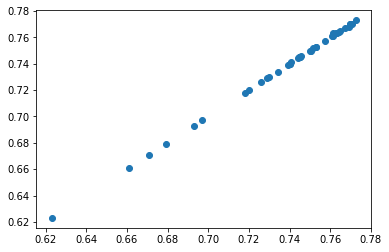

In [ ]:
plt.scatter(res[:,0], res[:,1])

In [ ]:
def calc_error(t_val, scores):
  err = 0.0
  for score in scores:
    auc_v = metrics.roc_auc_score(t_val.target, score[1].target)
    err  += (auc_v - score[0])**2
  return err

cnt = 0
total = len(df_val)
for index, row in tqdm(df_val.iterrows(), total=len(df_val)):
  df_val.loc[index, 'target'] = 0.0
  err0 = calc_error(df_val, scores)
  df_val.loc[index, 'target'] = 1.0
  err1 = calc_error(df_val, scores)
  if err0 == err1:
    cnt += 0

print(cnt)


In [ ]:
cnt

In [ ]:
df1 = pd.read_csv(file_name) 
df_val = pd.read_csv(VALIDATOR)  
  hist = plt.hist(df.target, bins=30)
  pos_thresh = 0.80
  neg_thresh = 0.80
  auc_v = metrics.roc_auc_score(df_val.target, df.target)